# V03
4 qubits with Purcell filter

In [1]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from scipy.optimize import fsolve
from modeling.utils.qubits import get_Ic_from_Lj, jaynes_cummings_g
from qucat import Network,L,J,C
from modeling.qubits.clockmon.libraries.clockmon_library import clockmon_coupling_libraries, clockmon_library, clockmon_cqr_to_ground
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_library, digit_tee_ck_to_ground, get_ck
from modeling.utils.constants import planck_h, e_charge, phi0
from scqubits import Transmon

In [2]:
smooth_capacitor_lib = digit_tee_library(deembed = [300, 200])
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])
clockmon_lib = clockmon_library(deembed = 200) 
cqr_to_ground = clockmon_cqr_to_ground(deembed = 200)

# Target Parameters

In [3]:
a = 10e-6 # conductor width
b = 6e-6 # gap width
ep_r = 11.45 # substrate relative permittivity

nb_qubits = 4 # number of qubits / readout resonators
rr_freq_target = np.array([7e9, 7.2e9, 7.4e9, 7.6e9])
qubit_freq_target = np.array([4.5e9, 4.7e9, 4.9e9, 5.1e9]) # target qubit frequencies
c_sigma = 90.47e-15 # target qubit shunt capacitance
kappa_target = 0.5e6 # target resonator linewidth
chi = 1.45e6 # target dispersive shift

Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq_target)
c_r = 1/((2*pi*rr_freq_target)**2*l_r)

In [4]:
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real # characteristic impedance of the CPW
l_r = Z0*pi/(4*pi*rr_freq_target) # Effective resonator L
c_r = 1/((2*pi*rr_freq_target)**2*l_r) # Effective resonator C

# Design optimization

In [5]:
def minimize_func(x, c_r = None, l_r = None, target_qubit_frequency = None):
    """Function to minimize the error in chi and qubit frequency by varying
    the coupling capacitor and Josephson inductance."""
    cir = Network([
        C(0, 1, c_sigma), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r), # resonator
        L(0,2,l_r),
        C(1,2, abs(x[0])*1e-15), # coupling capacitor
    ])
    err_chi = abs(cir.kerr(Lj = x[1]*1e-9)[0,1] - 2*chi)
    H = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = x[1]*1e-9)
    ee = H.eigenenergies().real
    ee -= ee[0]
    err_freq = abs(ee[1] - target_qubit_frequency)
    return err_chi, err_freq

In [6]:
cqrs = np.zeros((nb_qubits))
Ljs = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cqr, lj = fsolve(minimize_func, [6, 9], args =(c_r[i], l_r[i], qubit_freq_target[i]))
    cqrs[i] = cqr*1e-15
    Ljs[i] = lj*1e-9

print("Coupling capacitance for each qubit to their readout resonators [F]", cqrs)
print("Josephson inductance for each qubit [H]", Ljs)

Coupling capacitance for each qubit to their readout resonators [F] [9.65425690e-15 9.18859544e-15 8.76008039e-15 8.36458650e-15]
Josephson inductance for each qubit [H] [1.14155986e-08 1.05499365e-08 9.77936598e-09 9.09041036e-09]


In [7]:
Ic = get_Ic_from_Lj(Ljs)
EC = e_charge**2/(c_sigma)/2/planck_h
Ej = Ic*phi0/2/pi/planck_h
anharmonicities = np.zeros(nb_qubits)
for i in range(nb_qubits):
    transmon = Transmon(EJ = Ej[i], EC=EC, ng = 0, ncut = 31)
    anharmonicities[i] = transmon.anharmonicity()

Energy dispersion is  5.448211441040039e-07 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

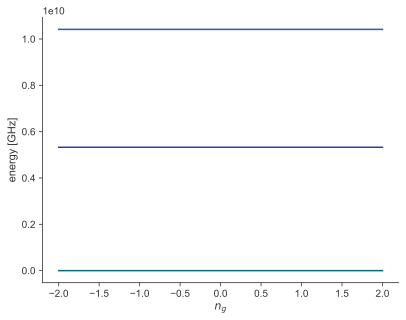

In [8]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej[0], EC=EC, ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [9]:
# Printout of the mode analysis for each qubit+resonator system
resonator_mode = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cir = Network([
        C(0,1,c_sigma), # transmon
        J(0,1, Ljs[i]),
        C(0,2,c_r[i]), # resonator
        L(0,2,l_r[i]),
        C(1,2, cqrs[i]), # coupling capacitor
        ])
    cir.f_k_A_chi(pretty_print=True)
    H  = cir.hamiltonian(modes = [0, 1],
                taylor = 6, excitations = [10, 10])
    ee = H.eigenenergies().real
    ee -= ee[0]
    resonator_mode[i] = ee[2]

         mode |       freq.  |       diss.  |       anha.  |
            0 |      4.7 GHz |          0Hz |      191 MHz |
            1 |      6.9 GHz |          0Hz |       11 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      191 MHz |              |
            1 |      2.9 MHz |       11 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |      4.9 GHz |          0Hz |      192 MHz |
            1 |      7.1 GHz |          0Hz |       11 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      192 MHz |              |
            1 |      2.9 MHz |       11 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |      5.1 GHz |          0Hz |      193 MHz |
            1 |      7.3 GHz |          0Hz |     10.9 kHz |

Kerr coefficients (diagonal = Kerr, off-diag

In [10]:
print("Loaded resonator frequencies", resonator_mode)
resonator_mode_shift = rr_freq_target - resonator_mode

Loaded resonator frequencies [6.90317032e+09 7.10204155e+09 7.30091612e+09 7.49979496e+09]


In [11]:
# Coupling strength and Lamb shift calculation (approximate)
gs = jaynes_cummings_g(Ej, EC, cqrs, c_r, rr_freq_target, lambda_half = False)
delta = (rr_freq_target - transmon.E01()) * 2*np.pi

lamb_shift = 2*gs**2 / delta
print("Coupling strengths g/2pi [Hz]: ", gs/2/pi)
print("Lamb shifts [Hz]: ", lamb_shift/2/pi)

Coupling strengths g/2pi [Hz]:  [2.30635225e+08 2.39539428e+08 2.48450315e+08 2.57367212e+08]
Lamb shifts [Hz]:  [63568193.20443253 61251439.67595202 59537747.12087502 58267974.76500706]


In [12]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0, lambda_half = False)/ 2/ pi
    return abs(k - kappa_target)
cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15
print("Coupling capacitance to feedline for each resonator [F]: ", cks)

Coupling capacitance to feedline for each resonator [F]:  [4.73130656e-15 4.53554421e-15 4.35291884e-15 4.18222853e-15]


In [13]:
adjusted_resonator_frequencies = rr_freq_target + resonator_mode_shift
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / adjusted_resonator_frequencies / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l))
c_r_loaded -= cqrs
c_r_loaded -= cks
resonator_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
resonator_waveguide_lengths

array([0.00824571, 0.00802257, 0.00781116, 0.00761061])

In [14]:
coupler_width_given_c_qr, c_sigma_given_coupler_width = clockmon_coupling_libraries()
ck_given_coupling = get_ck()
for i in range(nb_qubits):
    coupler_width = coupler_width_given_c_qr(cqrs[i])
    finger_control = ck_given_coupling(cks[i])
    print(f"Coupler width for qubit {i}: {coupler_width:.5} um")
    print(f"Finger control for qubit {i}: {finger_control:.5}")
    print(f"Resonator length for qubit {i}: {resonator_waveguide_lengths[i]*1e6:.5} um")

Coupler width for qubit 0: 350.26 um
Finger control for qubit 0: 1.6795
Resonator length for qubit 0: 8245.7 um
Coupler width for qubit 1: 329.42 um
Finger control for qubit 1: 1.6524
Resonator length for qubit 1: 8022.6 um
Coupler width for qubit 2: 310.55 um
Finger control for qubit 2: 1.6269
Resonator length for qubit 2: 7811.2 um
Coupler width for qubit 3: 293.34 um
Finger control for qubit 3: 1.603
Resonator length for qubit 3: 7610.6 um


# Quasi-lumped simulation

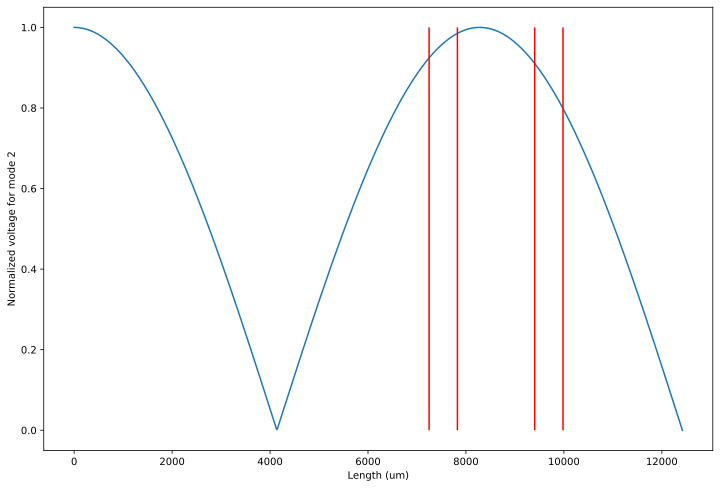

In [15]:
fl_traits = pd.read_csv("single_doublepads_03.csv").values[0][1:]
tee_size = pd.read_csv("single_doublepads_03.csv").values[1][1:]
res_length = pd.read_csv("single_doublepads_03.csv").values[2][1:]

tee_size = tee_size[pd.isna(tee_size) == 0]
res_length =res_length[pd.isna(res_length) == 0]

transmission_line_tee_points = [
    float(fl_traits[0]), # From input launcher to feedline capacitor
    fl_traits[1] + (a + 2*b)/2, # From feedline capacitor to tee0
    fl_traits[2] + (a + 2*b), # From tee0 to tee1
    fl_traits[3] + (a + 2*b), # From tee1 to tee2
    fl_traits[4] + (a + 2*b), # From tee2 to tee3
    # fl_traits[5] + (a + 2*b), # From tee3, to tee4 
    # fl_traits[6] + (a + 2*b), # From tee4, to tee5
    fl_traits[5] + (a + 2*b), # From tee5, to tee6 (from tee6 we split into output launcher and feedline resonator tail)
    fl_traits[6] + (a + 2*b)/2, # From tee6 to output launcher
    fl_traits[7] + 30, # from tee6 to ground (feedline resonator tail endpoint)
]

feedline_res_length = fl_traits[1] + (a + 2*b)/2 + \
    fl_traits[2] + (a + 2*b) + \
    fl_traits[3] + (a + 2*b) + \
    fl_traits[4] + (a + 2*b) + \
    fl_traits[5] + (a + 2*b) + \
    fl_traits[6] + 30 + fl_traits[7] + (a + 2*b)/2
qb_pos_0 = fl_traits[1] + (a + 2*b)/2
qb_pos_1 = qb_pos_0 + fl_traits[2] + (a + 2*b)
qb_pos_2 = qb_pos_1 + fl_traits[3] + (a + 2*b)
qb_pos_3 = qb_pos_2 + fl_traits[4] + (a + 2*b)

xdata = np.linspace(0, feedline_res_length, 1001)
plt.figure(figsize=(12, 8))
plt.ylabel("Normalized voltage for mode 2")
plt.xlabel("Length (um)")
def resonance_profile(x, total_length, order):
    return abs(np.cos(2*np.pi*x*(order + 1/2)/total_length/2))
plt.plot(xdata, resonance_profile(xdata, feedline_res_length, order = 1))
plt.vlines([qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3], ymin = 0, ymax = 1, colors="r")
corrections_to_ck = resonance_profile(np.array([qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3]), feedline_res_length, order = 1)

In [16]:
# resonator_capacitance = c_r_loaded - cks -  cqrs
# resonator_mode
l_r_mode = Z0*pi/(4*pi*resonator_mode)
c_r_mode = 1/((2*pi*resonator_mode)**2*l_r)- cks -  cqrs
cfl = 5e-14
options = {
    "qubit_c": np.array([c_sigma]*nb_qubits),
    "qubit_l": Ljs,
    "readout_resonator_c": c_r_mode,
    "readout_resonator_l": l_r_mode,
    "ck": cks,
    "ck_to_ground": ck_to_ground(cks),
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "cfl": cfl,
    "cfl_to_ground": ck_to_ground(cfl),
    "frequency": [2, 8],
    "n_points": 1001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}

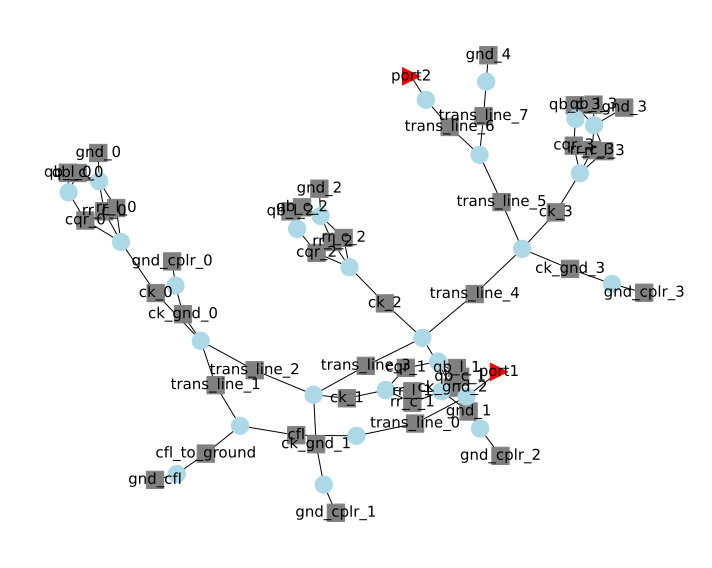

In [17]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)
ntw = cir.network

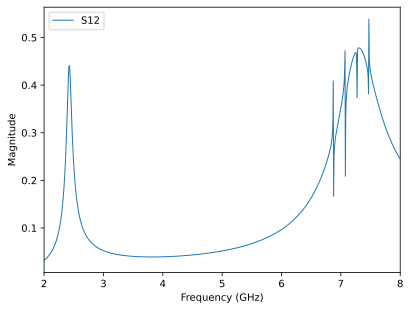

In [18]:
ntw.plot_s_mag(m=0, n=1, lw=1)

In [19]:
# T1 Purcell:
k_purcell = kappa_target* (gs/delta)**2
T1_purcell = 1/(2*np.pi*k_purcell)
print("T1 Purcell-limited [us]", T1_purcell)

T1 Purcell-limited [us] [1.67602951e-05 1.94729404e-05 2.21719774e-05 2.48402926e-05]


In [20]:
df = pd.DataFrame(['qb0','qb1','qb2', 'qb3'])
df['resonator 01 [GHz]'] = rr_freq_target / 1e9
df['qubit 01 [GHz]'] = qubit_freq_target / 1e9
df['anharmonicity [MHz]'] = anharmonicities / 1e6
df['chi/2pi [MHz]'] = [chi / 1e6]*nb_qubits
df['g/2pi [MHz]'] = gs/2/np.pi / 1e6
df['C_sigma [fF]'] = [c_sigma*1e15]*nb_qubits
df["Lj  [nH]"] = Ljs *1e9
df['Ic [nA]'] = Ic*1e9
df['T1 Purcell [us]'] = T1_purcell * 1e6
df.T

,0,1,2,3
0,qb0,qb1,qb2,qb3
resonator 01 [GHz],7.0,7.2,7.4,7.6
qubit 01 [GHz],4.5,4.7,4.9,5.1
anharmonicity [MHz],-240.383008,-239.089814,-237.922198,-236.861517
chi/2pi [MHz],1.45,1.45,1.45,1.45
g/2pi [MHz],230.635225,239.539428,248.450315,257.367212
C_sigma [fF],90.47,90.47,90.47,90.47
Lj [nH],11.415599,10.549936,9.779366,9.09041
Ic [nA],28.829498,31.195067,33.6531,36.203644
T1 Purcell [us],16.760295,19.47294,22.171977,24.840293
